# Predict and Extract Features with Pre-trained Models

This tutorial will work through how to use pre-trained models for predicting and feature extraction.

## Download pre-trained models

A model often contains two parts, the `.json` file specifying the neural network structure, and the `.params` file containing the binary parameters. The name convention is `name-symbol.json` and `name-epoch.params`, where `name` is the model name, and `epoch` is the epoch number. 


Here we download a pre-trained Resnet 50-layer model on Imagenet. Other models are available at http://data.mxnet.io/models/

In [1]:
import os, urllib
def download(url):
    filename = url.split("/")[-1]
    if not os.path.exists(filename):
        urllib.urlretrieve(url, filename)
def get_model(prefix, epoch):
    download(prefix+'-symbol.json')
    download(prefix+'-%04d.params' % (epoch,))

get_model('http://data.mxnet.io/models/imagenet/resnet/50-layers/resnet-50', 0)

## Initialization

We first load the model into memory with `load_checkpoint`. It returns the symbol (see [symbol.ipynb](../basic/symbol.ipynb)) definition of the neural network, and parameters. 

In [1]:
import mxnet as mx
sym, arg_params, aux_params = mx.model.load_checkpoint('resnet-50', 0)

In [11]:
arg_params.values

<function values>

In [2]:
internals = sym.get_internals()
internals.list_outputs()[-20:-1]

['stage4_unit3_conv2_weight',
 'stage4_unit3_conv2_output',
 'stage4_unit3_bn3_gamma',
 'stage4_unit3_bn3_beta',
 'stage4_unit3_bn3_output',
 'stage4_unit3_relu3_output',
 'stage4_unit3_conv3_weight',
 'stage4_unit3_conv3_output',
 '_plus15_output',
 'bn1_gamma',
 'bn1_beta',
 'bn1_output',
 'relu1_output',
 'pool1_output',
 'flatten0_output',
 'fc1_weight',
 'fc1_bias',
 'fc1_output',
 'softmax_label']

We can visualize the neural network by `mx.viz.plot_network`.

In [3]:
%matplotlib inline
mx.viz.plot_network(sym)

RuntimeError: failed to execute ['dot', '-Tsvg'], make sure the Graphviz executables are on your systems' path

Both argument parameters and auxiliary parameters (e.g mean/std in batch normalization layer) are stored as a dictionary of string name and ndarray value (see [ndarray.ipynb](../basic/ndarray.ipynb)). The arguments contain 
consist of weight and bias. 

In [6]:
arg_params

{'bn0_beta': <mxnet.ndarray.NDArray at 0x803e908>,
 'bn0_gamma': <mxnet.ndarray.NDArray at 0x802a6d8>,
 'bn1_beta': <mxnet.ndarray.NDArray at 0x8035d30>,
 'bn1_gamma': <mxnet.ndarray.NDArray at 0x803e2e8>,
 'bn_data_beta': <mxnet.ndarray.NDArray at 0x8020518>,
 'bn_data_gamma': <mxnet.ndarray.NDArray at 0x80356d8>,
 'conv0_weight': <mxnet.ndarray.NDArray at 0x802a8d0>,
 'fc1_bias': <mxnet.ndarray.NDArray at 0x80357b8>,
 'fc1_weight': <mxnet.ndarray.NDArray at 0x803e828>,
 'stage1_unit1_bn1_beta': <mxnet.ndarray.NDArray at 0x8035a90>,
 'stage1_unit1_bn1_gamma': <mxnet.ndarray.NDArray at 0x8035160>,
 'stage1_unit1_bn2_beta': <mxnet.ndarray.NDArray at 0x80359b0>,
 'stage1_unit1_bn2_gamma': <mxnet.ndarray.NDArray at 0x802a358>,
 'stage1_unit1_bn3_beta': <mxnet.ndarray.NDArray at 0x80354a8>,
 'stage1_unit1_bn3_gamma': <mxnet.ndarray.NDArray at 0x80359e8>,
 'stage1_unit1_conv1_weight': <mxnet.ndarray.NDArray at 0x802a080>,
 'stage1_unit1_conv2_weight': <mxnet.ndarray.NDArray at 0x8020e48>,
 

while auxiliaries contains the the mean and std for the batch normalization layers.   

In [22]:
aux_params

{'bn0_moving_mean': <mxnet.ndarray.NDArray at 0x8020400>,
 'bn0_moving_var': <mxnet.ndarray.NDArray at 0x8035828>,
 'bn1_moving_mean': <mxnet.ndarray.NDArray at 0x8020ef0>,
 'bn1_moving_var': <mxnet.ndarray.NDArray at 0x802a470>,
 'bn_data_moving_mean': <mxnet.ndarray.NDArray at 0x802a3c8>,
 'bn_data_moving_var': <mxnet.ndarray.NDArray at 0x8020940>,
 'stage1_unit1_bn1_moving_mean': <mxnet.ndarray.NDArray at 0x8020f98>,
 'stage1_unit1_bn1_moving_var': <mxnet.ndarray.NDArray at 0x802a550>,
 'stage1_unit1_bn2_moving_mean': <mxnet.ndarray.NDArray at 0x803e748>,
 'stage1_unit1_bn2_moving_var': <mxnet.ndarray.NDArray at 0x8035208>,
 'stage1_unit1_bn3_moving_mean': <mxnet.ndarray.NDArray at 0x803e0b8>,
 'stage1_unit1_bn3_moving_var': <mxnet.ndarray.NDArray at 0x802acc0>,
 'stage1_unit2_bn1_moving_mean': <mxnet.ndarray.NDArray at 0x802acf8>,
 'stage1_unit2_bn1_moving_var': <mxnet.ndarray.NDArray at 0x8035d68>,
 'stage1_unit2_bn2_moving_mean': <mxnet.ndarray.NDArray at 0x802a908>,
 'stage1_uni

Next we create an executable `module` (see [module.ipynb](../basic/module.ipynb)) on GPU 0. To use a difference device, we just need to charge the context, e.g. `mx.cpu()` for CPU and `mx.gpu(2)` for the 3rd GPU. 

In [20]:
mod = mx.mod.Module(symbol=sym, context=mx.cpu())

The ResNet is trained with RGB images of size 224 x 224. The training data is feed by the variable `data`. We bind the module with the input shape and specify that it is only for predicting. The number 1 added before the image shape (3x224x224) means that we will only predict one image each time. Next we set the loaded parameters. Now the module is ready to run. 

In [21]:
mod.bind(for_training = False,
         data_shapes=[('data', (1,3,224,224))])
mod.set_params(arg_params, aux_params)

## Prepare data

We first obtain the synset file, in which the i-th line contains the label for the i-th class.

In [5]:
# download('http://data.mxnet.io/models/imagenet/resnet/synset.txt')
with open('D:\gitcode\DataScience\RMxnet\inception-bn\synset.txt') as f:
    synsets = [l.rstrip() for l in f]

In [9]:
synsets[1:10]

['n01443537 goldfish, Carassius auratus',
 'n01484850 great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 'n01491361 tiger shark, Galeocerdo cuvieri',
 'n01494475 hammerhead, hammerhead shark',
 'n01496331 electric ray, crampfish, numbfish, torpedo',
 'n01498041 stingray',
 'n01514668 cock',
 'n01514859 hen',
 'n01518878 ostrich, Struthio camelus']

We next download 1000 images for testing, which were not used for the training. 

In [12]:
# import tarfile
# download('http://data.mxnet.io/data/val_1000.tar')
# tfile = tarfile.open('val_1000.tar')
# tfile.extractall()
with open('val_1000/label') as f:
    val_label = [int(l.split('\t')[0]) for l in f]

Visualize the first 8 images.

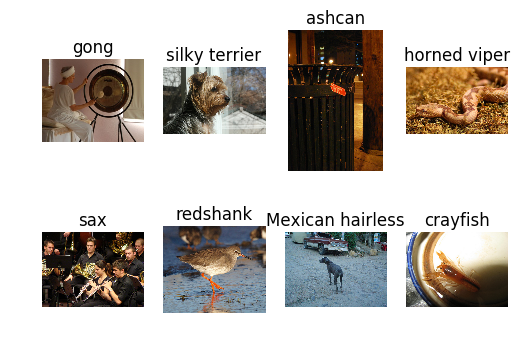

In [16]:
%matplotlib inline
import matplotlib
matplotlib.rc("savefig", dpi=100)
import matplotlib.pyplot as plt
import cv2
for i in range(0,8):
    img = cv2.cvtColor(cv2.imread('val_1000/%d.jpg' % (i,)), cv2.COLOR_BGR2RGB)
    plt.subplot(2,4,i+1)
    plt.imshow(img)
    plt.axis('off')
    label = synsets[val_label[i]]
    label = ' '.join(label.split(',')[0].split(' ')[1:])
    plt.title(label)

Next we define a function that reads one image each time and convert to a format can be used by the model. Here we use a naive way that resizes the original image into the desired shape, and change the data layout. 

In [17]:
import numpy as np
import cv2
def get_image(filename):
    img = cv2.imread(filename)  # read image in b,g,r order
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   # change to r,g,b order
    img = cv2.resize(img, (224, 224))  # resize to 224*224 to fit model
    img = np.swapaxes(img, 0, 2)
    img = np.swapaxes(img, 1, 2)  # change to (channel, height, width)
    img = img[np.newaxis, :]  # extend to (example, channel, heigth, width)
    return img

Finally we define a input data structure which is acceptable by mxnet. The field `data` is used for the input data, which is a list of NDArrays. 

In [18]:
from collections import namedtuple
Batch = namedtuple('Batch', ['data'])

## Predict

Now we are ready to run the prediction by `forward`. Then we can get the output using `get_outputs`, in which the i-th element is the predicted probability that the image contains the i-th class. 

In [37]:
img = get_image('val_1000/0.jpg')
# img = get_image('C:/Program Files/R/R-3.3.2/library/imager/extdata/parrots.png')
mod.forward(Batch([mx.nd.array(img)]))
prob = mod.get_outputs()[0].asnumpy()
y = np.argsort(np.squeeze(prob))[::-1]
print('truth label %d; top-1 predict label %d' % (val_label[0], y[0]))

truth label 577; top-1 predict label 577


In [42]:
img = get_image('val_1000/0.jpg')
img.ndim

4

When predicting more than one images, we can batch several images together which potentially improves the performance. 

In [43]:
batch_size = 32
mod2 = mx.mod.Module(symbol=sym, context=mx.cpu())  # change to cpu
mod2.bind(for_training=False, data_shapes=[('data', (batch_size,3,224,224))])
mod2.set_params(arg_params, aux_params)

Now we iterative multiple images to calculate the accuracy

In [44]:
import time
acc = 0.0
total = 0.0
for i in range(0, 200/batch_size):
    tic = time.time()
    idx = range(i*batch_size, (i+1)*batch_size)
    img = np.concatenate([get_image('val_1000/%d.jpg'%(j)) for j in idx])
    mod2.forward(Batch([mx.nd.array(img)]))
    prob = mod2.get_outputs()[0].asnumpy()
    pred = np.argsort(prob, axis=1)
    top1 = pred[:,-1]
    acc += sum(top1 == np.array([val_label[j] for j in idx]))
    total += len(idx)
    print('batch %d, time %f sec'%(i, time.time()-tic))
print('top-1 accuracy %f'%(acc/total))

batch 0, time 16.197000 sec
batch 1, time 16.398000 sec
batch 2, time 15.893000 sec
batch 3, time 16.556000 sec
batch 4, time 16.236000 sec
batch 5, time 16.188000 sec
top-1 accuracy 0.645833


## Extract Features

Sometime we want the internal outputs from a neural network rather than then final predicted probabilities. In this way, the neural network works as a feature extraction module to other applications. 

A loaded symbol in default only returns the last layer as output. But we can get all internal layers by `get_internals`, which returns a new symbol outputting all internal layers. The following codes print the last 10 layer names. 

We can also use `mx.viz.plot_network(sym)` to visually find the name of the layer we want to use. The name conventions of the output is the layer name with `_output` as the postfix.

In [45]:
all_layers = sym.get_internals()
all_layers.list_outputs()[-10:-1]

['bn1_beta',
 'bn1_output',
 'relu1_output',
 'pool1_output',
 'flatten0_output',
 'fc1_weight',
 'fc1_bias',
 'fc1_output',
 'softmax_label']

Often we want to use the output before the last fully connected layers, which may return semantic features of the raw images but not too fitting to the label yet. In the ResNet case, it is the flatten layer with name `flatten0` before the last fullc layer. The following codes get the new symbol `sym3` which use the flatten layer as the last output layer, and initialize a new module.

In [47]:
all_layers = sym.get_internals()
sym3 = all_layers['flatten0_output']
mod3 = mx.mod.Module(symbol=sym3, context=mx.cpu())
mod3.bind(for_training=False, data_shapes=[('data', (1,3,224,224))])
mod3.set_params(arg_params, aux_params)

Now we can do feature extraction using `forward1` as before. Notice that the last convolution layer uses 2048 channels, and we then perform an average pooling, so the output size of the flatten layer is 2048.

In [49]:
img = get_image('val_1000/0.jpg')
mod3.forward(Batch([mx.nd.array(img)]))
out = mod3.get_outputs()[0].asnumpy()
print(out.shape)
out

(1L, 2048L)


array([[ 0.03103645,  0.        ,  0.7953214 , ...,  0.417822  ,
         0.73394692,  0.36429754]], dtype=float32)

In [57]:
mod3.get_outputs()[0].asnumpy()

array([[ 0.03103645,  0.        ,  0.7953214 , ...,  0.417822  ,
         0.73394692,  0.36429754]], dtype=float32)

## Further Readings
